In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from util.cer_util import MCData
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
import scipy.stats
import util.theory as theory

In [46]:
plt.style.use('stylesheets/eloss.mplstyle')

In [85]:
computed_data = [(0, 0), (1, 0), (2, 0), (4, 0), (6, 0), (10, 0),
                         (0, -1), (0, -0.5), (0, 0.5), (0, 1)]
for i, (s, b) in enumerate(computed_data):
    computed_data[i] = MCData(s,b)

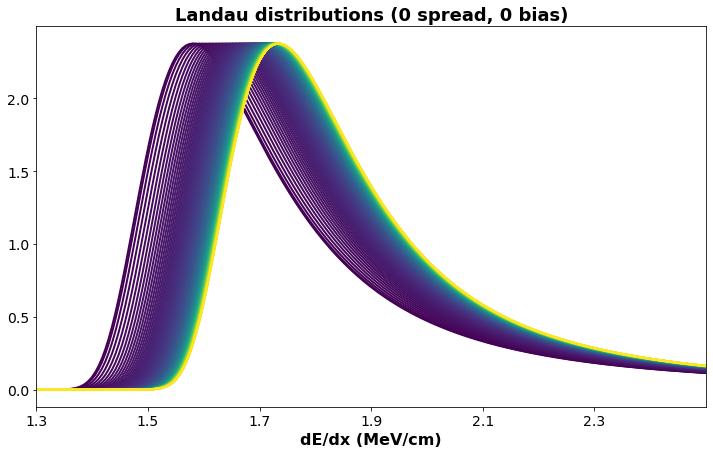

In [96]:
import matplotlib.colors as colors
params = computed_data[0].fit_data[['mpv', 'eta', 'sigma']]
num_bins = params.shape[0]
xrange = np.linspace(0,6,1000)
plotter = params.groupby(level=0).apply(lambda param: pd.Series(theory.langau_pdf(xrange, *param.values[0]), index=xrange.astype(str))).T.reset_index()
plotter['index'] = plotter['index'].astype(float)
fig = plotter.plot(x='index', legend=False, xticks=np.arange(1.3,2.5,0.2), ls='-', colormap='viridis')
plt.xlim(1.3,2.5)
plt.xlabel('dE/dx (MeV/cm)')
plt.title('Landau distributions (0 spread, 0 bias)')
plt.grid(False)


In [97]:
def get_binned_diff_dist(fractional_deviation, density=False):
    bins = np.arange(-1, 1.1, 0.1)
    counts, _ = np.histogram(fractional_deviation, bins, density=density)
    
    return bins, counts


def gaussdiff(df):
    diff = df['difference']
    truth = df['truth']
    fractional_deviation = diff/truth
    bins, counts = get_binned_diff_dist(fractional_deviation)
    
    bcenters = (bins[1:] + bins[:-1]) / 2
    
    raw_mean = np.mean(fractional_deviation)
    raw_std = np.std(fractional_deviation)
    raw_sig_for_fit = 3
    
    mask = np.abs(bcenters - raw_mean) < raw_sig_for_fit * raw_std
    masked_bcenters = bcenters[mask]
    masked_counts = counts[mask]
    
    def gaussian(x, mu, sig):
        return scipy.stats.norm.pdf(x, mu, sig)
    
    bw = (bins[1:]-bins[:-1])[mask]
    anorm = np.sum(masked_counts*bw)
    popt, pcov = curve_fit(gaussian, masked_bcenters, masked_counts/anorm)
    
    perr = np.sqrt(np.diag(pcov))
    return (np.concatenate((popt, perr, [truth.min(), truth.max(), anorm])), bcenters, counts)

In [98]:
def plot_frac_dev_dist(ax, centers, counts, gdata):
    mu, sig, muerr, sigerr, e_min, e_max, A = gdata
    ax.grid(False)
    ax.hist(centers, len(centers), weights=counts, color='tab:orange', edgecolor='black', lw=1.2,
           label=f"{counts.sum()} Entries")
    ax.set_title(r'$E_{T}\in$' + f'[{np.floor(e_min)},{np.ceil(e_max)}] GeV', fontweight='normal', fontsize=14)
    
    x = np.linspace(-2, 2, 1000)
    ax.plot(x, scipy.stats.norm.pdf(x, mu, sig) * A, ls='--', lw=2,
           label="Gauss Fit\n" + fr"$\mu=${mu:.2f}" + "\n" + fr"$\sigma=${sig:.2f}")
    ax.legend(loc='upper right', fontsize=12)

In [99]:
def plot_frac_dev_dists(mcdata, show=False):
    fitdf = mcdata.fit_data
    likedf = mcdata.reconstruction
    likedf['reco'] = likedf[['reconstructed_min', 'reconstructed_max']].mean(axis=1)
    likedf['difference'] = likedf.reco - likedf.truth

    muons_per_ebin = likedf.shape[0] / likedf.truebin.unique().shape[0]
    num_bins = fitdf.shape[0]

    if show:
        fig, axes = plt.subplots(3,3,figsize=(15,12))
    gaussian_data = []
    for i, idx in tqdm(list(enumerate(likedf.truebin.unique()[::10]))):
        df = likedf.loc[(likedf.truebin >= idx) & (likedf.truebin < idx + 10)]
        gdata, bcenters, counts = gaussdiff(df)
        gaussian_data.append(gdata)

    if show:
        ax = axes.flatten(i)
        plot_frac_dev_dist(ax, bcenters, counts, gdata)
        fig.tight_layout()
        fig.show()
        
    return pd.DataFrame(gaussian_data, columns=['gloc', 'gwidth', 'gloc_err', 'gwidth_err', 'true_e_min', 'true_e_max', 'A'])
    

In [201]:
def plot_2d_hist(mcdata):
    fitdf = mcdata.fit_data
    likedf = mcdata.reconstruction
    
    ebins = fitdf.e_min.to_list()
    ebins.append(fitdf.e_max.iloc[-1])
    ebins = np.array(ebins)
    
    x = np.linspace(1, 10, 1000)

    truth = likedf.truth
    reconstructed = likedf[["reconstructed_min", "reconstructed_max"]].mean(1)
    
    fig = plt.figure(figsize=(7.05,6))
    ax = fig.gca()
    counts, xedges, yedges, im = ax.hist2d(truth, reconstructed, bins=[ebins,ebins], cmap='gist_heat_r',
                                         norm=LogNorm(vmin=0.7),
                                         )
    fig.colorbar(im, ax=ax, aspect=20, label='count', ticks=[1,5,10,50])
    ax.plot(x, x, color='k', ls='--') # Plot the expectation, which is ideally perfect reconstruction (a 45 degree line)
    ax.set_xlabel('True Energy (GeV)')
    ax.set_ylabel('Reconstructed Energy (GeV)')
    ax.set_title('TE vs. RE')
    ax.set_xlim(1,10)
    ax.set_ylim(1,10)
    return counts, xedges, yedges

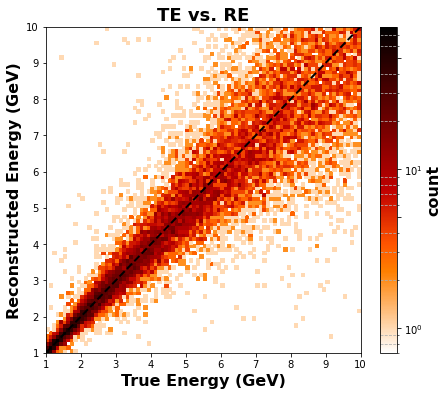

In [202]:
plot_2d_hist(computed_data[0])
plt.show()

In [100]:
for data in computed_data:
    gausses = plot_frac_dev_dists(data)
    data.gausses = gausses

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

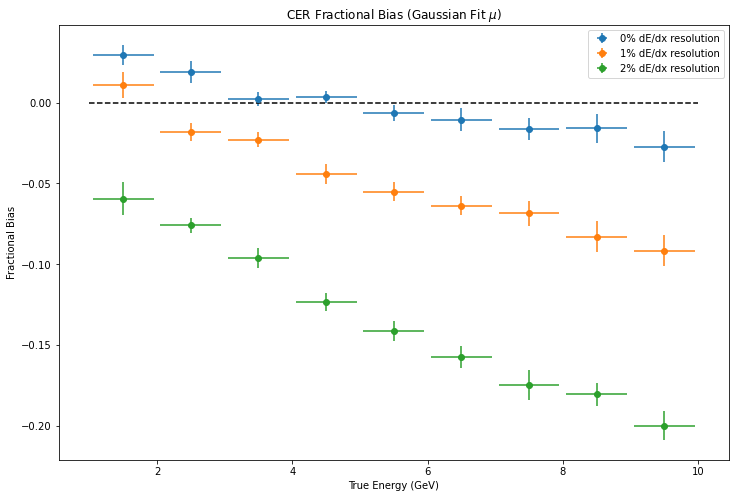

In [7]:
def plot_one_bias(mcdata):
    gausses = mcdata.gausses
    truth = (gausses.true_e_max + gausses.true_e_min) / 2
    xerr = (gausses.true_e_max - gausses.true_e_min) / 2
    pct_bias = gausses.gloc
    pct_bias_err = gausses.gloc_err
    plt.errorbar(truth, pct_bias, yerr=pct_bias_err, xerr=xerr, marker='o', ls='', label=f'{mcdata.spread_pct}% dE/dx resolution')

plt.figure(figsize=(12,8))
plt.plot([1,10], [0,0], ls='--', c='black')
for data in computed_data:
    if data.bias_pct == 0 and data.spread_pct <= 2:
        plot_one_bias(data)
plt.title(r'CER Fractional Bias (Gaussian Fit $\mu$)')
plt.xlabel('True Energy (GeV)')
plt.ylabel('Fractional Bias')
plt.legend()
plt.show()

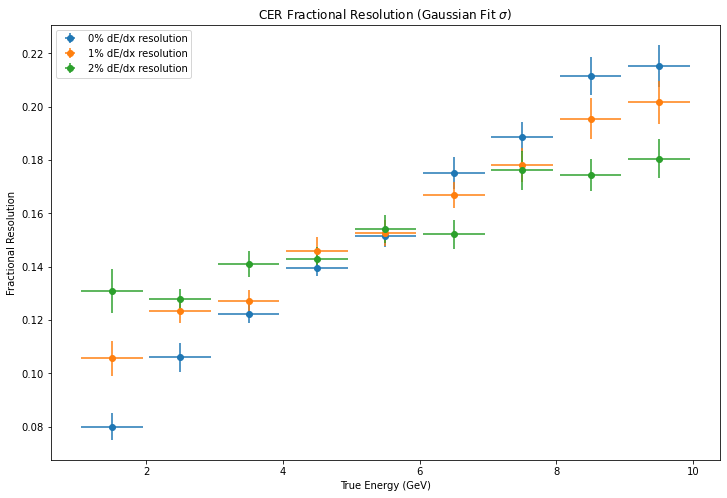

In [8]:
def plot_one_resolution(mcdata):
    gausses = mcdata.gausses
    truth = (gausses.true_e_max + gausses.true_e_min) / 2
    xerr = (gausses.true_e_max - gausses.true_e_min) / 2
    pct_resolution = gausses.gwidth
    pct_resolution_err = gausses.gwidth_err
    plt.errorbar(truth, pct_resolution, yerr=pct_resolution_err, xerr=xerr, marker='o', ls='', label=f'{mcdata.spread_pct}% dE/dx resolution')

plt.figure(figsize=(12,8))
plt.title(r'CER Fractional Resolution (Gaussian Fit $\sigma$)')
plt.xlabel('True Energy (GeV)')
plt.ylabel('Fractional Resolution')
for data in computed_data:
    if data.bias_pct == 0 and data.spread_pct <= 2:
        plot_one_resolution(data)
plt.legend()
plt.show()